<a href="https://colab.research.google.com/github/rachanashinde15/DemoGIt/blob/master/Resnet_Thesis_Final_7layeroutputnew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import datasets,models,layers


In [12]:
# Adding TF Cifar10 Data ..
from keras.datasets import cifar100
(X_train, Y_train), (X_test, Y_test) = cifar100.load_data()

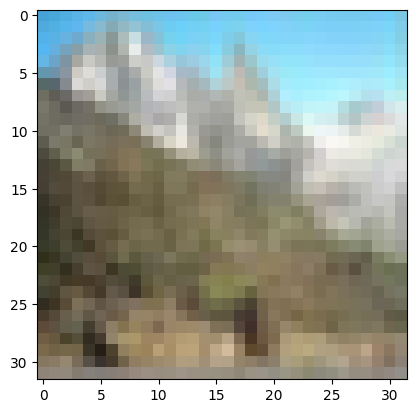

In [13]:
# Drawing sample .
plt.imshow(X_train[42])

In [14]:
# Normalize the data.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2,shuffle = True)

In [16]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(Y_train)
Y_train = encoder.transform(Y_train).toarray()
Y_test = encoder.transform(Y_test).toarray()
Y_val =  encoder.transform(Y_val).toarray()

In [17]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

In [18]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):
    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2, padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out


In [19]:
model = ResNet18(100)
model.build(input_shape = (None,32,32,3))
#use categorical_crossentropy since the label is one-hot encoded
from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_18 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 resnet_block_7 (ResnetBlock  multiple                 74368     
 )                                                               
                                                  

Epoch 1/20
157/156 [==============================] - ETA: 0s - loss: 3.6951 - accuracy: 0.1500

156/156 [==============================] - 40s 173ms/step - loss: 3.6951 - accuracy: 0.1500 - val_loss: 4.1826 - val_accuracy: 0.1176
Epoch 2/20
157/156 [==============================] - ETA: 0s - loss: 3.0400 - accuracy: 0.2513

156/156 [==============================] - 24s 152ms/step - loss: 3.0400 - accuracy: 0.2513 - val_loss: 4.9599 - val_accuracy: 0.0985
Epoch 3/20
157/156 [==============================] - ETA: 0s - loss: 2.7101 - accuracy: 0.3112

156/156 [==============================] - 26s 164ms/step - loss: 2.7101 - accuracy: 0.3112 - val_loss: 2.9874 - val_accuracy: 0.2775
Epoch 4/20
157/156 [==============================] - ETA: 0s - loss: 2.4545 - accuracy: 0.3618

156/156 [==============================] - 23s 148ms/step - loss: 2.4545 - accuracy: 0.3618 - val_loss: 2.6578 - val_accuracy: 0.3258
Epoch 5/20
157/156 [==============================] - ETA: 0s - loss: 2.2534 - accuracy: 0.4055

156/156 [==============================] - 23s 149ms/step - loss: 2.2534 - accuracy: 0.4055 - val_loss: 2.5375 - val_accuracy: 0.3552
Epoch 6/20
157/156 [==============================] - ETA: 0s - loss: 2.0920 - accuracy: 0.4424

156/156 [==============================] - 23s 150ms/step - loss: 2.0920 - accuracy: 0.4424 - val_loss: 2.4912 - val_accuracy: 0.3706
Epoch 7/20
157/156 [==============================] - ETA: 0s - loss: 1.9243 - accuracy: 0.4807

156/156 [==============================] - 25s 159ms/step - loss: 1.9243 - accuracy: 0.4807 - val_loss: 2.2915 - val_accuracy: 0.4164
Epoch 8/20
157/156 [==============================] - ETA: 0s - loss: 1.8061 - accuracy: 0.5074

156/156 [==============================] - 23s 150ms/step - loss: 1.8061 - accuracy: 0.5074 - val_loss: 2.0758 - val_accuracy: 0.4545
Epoch 9/20
157/156 [==============================] - ETA: 0s - loss: 1.6816 - accuracy: 0.5325

156/156 [==============================] - 24s 151ms/step - loss: 1.6816 - accuracy: 0.5325 - val_loss: 2.4567 - val_accuracy: 0.3829
Epoch 10/20
157/156 [==============================] - ETA: 0s - loss: 1.5487 - accuracy: 0.5643

156/156 [==============================] - 24s 154ms/step - loss: 1.5487 - accuracy: 0.5643 - val_loss: 1.6267 - val_accuracy: 0.5436
Epoch 11/20
157/156 [==============================] - ETA: 0s - loss: 1.4175 - accuracy: 0.5967

156/156 [==============================] - 23s 146ms/step - loss: 1.4175 - accuracy: 0.5967 - val_loss: 2.2110 - val_accuracy: 0.4469
Epoch 12/20
157/156 [==============================] - ETA: 0s - loss: 1.3202 - accuracy: 0.6231

156/156 [==============================] - 24s 151ms/step - loss: 1.3202 - accuracy: 0.6231 - val_loss: 1.4560 - val_accuracy: 0.5871
Epoch 13/20
157/156 [==============================] - ETA: 0s - loss: 1.1903 - accuracy: 0.6566

156/156 [==============================] - 25s 160ms/step - loss: 1.1903 - accuracy: 0.6566 - val_loss: 1.3110 - val_accuracy: 0.6188
Epoch 14/20
157/156 [==============================] - ETA: 0s - loss: 1.0832 - accuracy: 0.6855

156/156 [==============================] - 25s 157ms/step - loss: 1.0832 - accuracy: 0.6855 - val_loss: 1.0882 - val_accuracy: 0.6802
Epoch 15/20
157/156 [==============================] - ETA: 0s - loss: 0.9720 - accuracy: 0.7118

156/156 [==============================] - 24s 157ms/step - loss: 0.9720 - accuracy: 0.7118 - val_loss: 0.9932 - val_accuracy: 0.7049
Epoch 16/20
157/156 [==============================] - ETA: 0s - loss: 0.8798 - accuracy: 0.7365

156/156 [==============================] - 25s 158ms/step - loss: 0.8798 - accuracy: 0.7365 - val_loss: 1.0481 - val_accuracy: 0.6850
Epoch 17/20
157/156 [==============================] - ETA: 0s - loss: 0.8047 - accuracy: 0.7579

156/156 [==============================] - 23s 146ms/step - loss: 0.8047 - accuracy: 0.7579 - val_loss: 1.0451 - val_accuracy: 0.6893
Epoch 18/20
157/156 [==============================] - ETA: 0s - loss: 0.7227 - accuracy: 0.7814

156/156 [==============================] - 24s 151ms/step - loss: 0.7227 - accuracy: 0.7814 - val_loss: 0.8662 - val_accuracy: 0.7376
Epoch 19/20
157/156 [==============================] - ETA: 0s - loss: 0.6366 - accuracy: 0.8080

156/156 [==============================] - 24s 155ms/step - loss: 0.6366 - accuracy: 0.8080 - val_loss: 1.1208 - val_accuracy: 0.6829
Epoch 20/20
157/156 [==============================] - ETA: 0s - loss: 0.5601 - accuracy: 0.8288

156/156 [==============================] - 23s 150ms/step - loss: 0.5601 - accuracy: 0.8288 - val_loss: 0.9925 - val_accuracy: 0.7111
Epoch 1/20
157/156 [==============================] - ETA: 0s - loss: 0.5249 - accuracy: 0.8370

156/156 [==============================] - 25s 157ms/step - loss: 0.5249 - accuracy: 0.8370 - val_loss: 0.9026 - val_accuracy: 0.7351
Epoch 2/20
157/156 [==============================] - ETA: 0s - loss: 0.4640 - accuracy: 0.8575

156/156 [==============================] - 23s 147ms/step - loss: 0.4640 - accuracy: 0.8575 - val_loss: 0.5036 - val_accuracy: 0.8422
Epoch 3/20
157/156 [==============================] - ETA: 0s - loss: 0.4226 - accuracy: 0.8704

156/156 [==============================] - 23s 149ms/step - loss: 0.4226 - accuracy: 0.8704 - val_loss: 0.4590 - val_accuracy: 0.8562
Epoch 4/20
157/156 [==============================] - ETA: 0s - loss: 0.3812 - accuracy: 0.8807

156/156 [==============================] - 23s 149ms/step - loss: 0.3812 - accuracy: 0.8807 - val_loss: 0.3556 - val_accuracy: 0.8886
Epoch 5/20
157/156 [==============================] - ETA: 0s - loss: 0.3357 - accuracy: 0.8964

156/156 [==============================] - 23s 145ms/step - loss: 0.3357 - accuracy: 0.8964 - val_loss: 0.4993 - val_accuracy: 0.8434
Epoch 6/20
157/156 [==============================] - ETA: 0s - loss: 0.3377 - accuracy: 0.8925

156/156 [==============================] - 23s 148ms/step - loss: 0.3377 - accuracy: 0.8925 - val_loss: 0.3320 - val_accuracy: 0.8960
Epoch 7/20
157/156 [==============================] - ETA: 0s - loss: 0.3109 - accuracy: 0.9020

156/156 [==============================] - 23s 147ms/step - loss: 0.3109 - accuracy: 0.9020 - val_loss: 0.2958 - val_accuracy: 0.9068
Epoch 8/20
157/156 [==============================] - ETA: 0s - loss: 0.2861 - accuracy: 0.9097

156/156 [==============================] - 22s 144ms/step - loss: 0.2861 - accuracy: 0.9097 - val_loss: 0.2869 - val_accuracy: 0.9090
Epoch 9/20
157/156 [==============================] - ETA: 0s - loss: 0.2691 - accuracy: 0.9150

156/156 [==============================] - 23s 146ms/step - loss: 0.2691 - accuracy: 0.9150 - val_loss: 0.3137 - val_accuracy: 0.8993
Epoch 10/20
157/156 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.9151

156/156 [==============================] - 24s 155ms/step - loss: 0.2623 - accuracy: 0.9151 - val_loss: 0.5650 - val_accuracy: 0.8283
Epoch 11/20
157/156 [==============================] - ETA: 0s - loss: 0.2516 - accuracy: 0.9180

156/156 [==============================] - 24s 154ms/step - loss: 0.2516 - accuracy: 0.9180 - val_loss: 0.4016 - val_accuracy: 0.8719
Epoch 12/20
157/156 [==============================] - ETA: 0s - loss: 0.2243 - accuracy: 0.9284

156/156 [==============================] - 24s 154ms/step - loss: 0.2243 - accuracy: 0.9284 - val_loss: 0.4799 - val_accuracy: 0.8545
Epoch 13/20
157/156 [==============================] - ETA: 0s - loss: 0.2223 - accuracy: 0.9308

156/156 [==============================] - 23s 149ms/step - loss: 0.2223 - accuracy: 0.9308 - val_loss: 0.1758 - val_accuracy: 0.9428
Epoch 14/20
157/156 [==============================] - ETA: 0s - loss: 0.2142 - accuracy: 0.9324

156/156 [==============================] - 23s 144ms/step - loss: 0.2142 - accuracy: 0.9324 - val_loss: 0.2208 - val_accuracy: 0.9275
Epoch 15/20
157/156 [==============================] - ETA: 0s - loss: 0.2080 - accuracy: 0.9344

156/156 [==============================] - 23s 149ms/step - loss: 0.2080 - accuracy: 0.9344 - val_loss: 0.2984 - val_accuracy: 0.9047
Epoch 16/20
157/156 [==============================] - ETA: 0s - loss: 0.2049 - accuracy: 0.9337

156/156 [==============================] - 23s 148ms/step - loss: 0.2049 - accuracy: 0.9337 - val_loss: 0.2541 - val_accuracy: 0.9184
Epoch 17/20
157/156 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.9414

156/156 [==============================] - 23s 150ms/step - loss: 0.1870 - accuracy: 0.9414 - val_loss: 0.4178 - val_accuracy: 0.8677
Epoch 18/20
157/156 [==============================] - ETA: 0s - loss: 0.2025 - accuracy: 0.9335

156/156 [==============================] - 23s 149ms/step - loss: 0.2025 - accuracy: 0.9335 - val_loss: 0.2854 - val_accuracy: 0.9070
Epoch 19/20
157/156 [==============================] - ETA: 0s - loss: 0.1896 - accuracy: 0.9386

156/156 [==============================] - 22s 141ms/step - loss: 0.1896 - accuracy: 0.9386 - val_loss: 0.1637 - val_accuracy: 0.9468
Epoch 20/20
157/156 [==============================] - ETA: 0s - loss: 0.1816 - accuracy: 0.9421

156/156 [==============================] - 24s 155ms/step - loss: 0.1816 - accuracy: 0.9421 - val_loss: 0.3091 - val_accuracy: 0.9042
Epoch 1/20
157/156 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.9449

156/156 [==============================] - 25s 161ms/step - loss: 0.1682 - accuracy: 0.9449 - val_loss: 0.5057 - val_accuracy: 0.8514
Epoch 2/20
157/156 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.9441

156/156 [==============================] - 22s 141ms/step - loss: 0.1752 - accuracy: 0.9441 - val_loss: 0.2690 - val_accuracy: 0.9141
Epoch 3/20
157/156 [==============================] - ETA: 0s - loss: 0.1717 - accuracy: 0.9456

156/156 [==============================] - 23s 147ms/step - loss: 0.1717 - accuracy: 0.9456 - val_loss: 0.2079 - val_accuracy: 0.9328
Epoch 4/20
157/156 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.9475

156/156 [==============================] - 24s 153ms/step - loss: 0.1637 - accuracy: 0.9475 - val_loss: 0.1961 - val_accuracy: 0.9353
Epoch 5/20
157/156 [==============================] - ETA: 0s - loss: 0.1550 - accuracy: 0.9506

156/156 [==============================] - 24s 151ms/step - loss: 0.1550 - accuracy: 0.9506 - val_loss: 0.4553 - val_accuracy: 0.8650
Epoch 6/20
157/156 [==============================] - ETA: 0s - loss: 0.1564 - accuracy: 0.9506

156/156 [==============================] - 23s 149ms/step - loss: 0.1564 - accuracy: 0.9506 - val_loss: 0.3620 - val_accuracy: 0.8915
Epoch 7/20
157/156 [==============================] - ETA: 0s - loss: 0.1454 - accuracy: 0.9542

156/156 [==============================] - 24s 154ms/step - loss: 0.1454 - accuracy: 0.9542 - val_loss: 0.4058 - val_accuracy: 0.8792
Epoch 8/20
157/156 [==============================] - ETA: 0s - loss: 0.1524 - accuracy: 0.9509

156/156 [==============================] - 23s 148ms/step - loss: 0.1524 - accuracy: 0.9509 - val_loss: 0.2903 - val_accuracy: 0.9093
Epoch 9/20
157/156 [==============================] - ETA: 0s - loss: 0.1565 - accuracy: 0.9496

156/156 [==============================] - 22s 141ms/step - loss: 0.1565 - accuracy: 0.9496 - val_loss: 0.2187 - val_accuracy: 0.9293
Epoch 10/20
157/156 [==============================] - ETA: 0s - loss: 0.1388 - accuracy: 0.9549

156/156 [==============================] - 24s 154ms/step - loss: 0.1388 - accuracy: 0.9549 - val_loss: 0.3416 - val_accuracy: 0.9012
Epoch 11/20
157/156 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.9557

156/156 [==============================] - 23s 148ms/step - loss: 0.1345 - accuracy: 0.9557 - val_loss: 0.3569 - val_accuracy: 0.8946
Epoch 12/20
157/156 [==============================] - ETA: 0s - loss: 0.1325 - accuracy: 0.9569

156/156 [==============================] - 24s 153ms/step - loss: 0.1325 - accuracy: 0.9569 - val_loss: 0.2863 - val_accuracy: 0.9102
Epoch 13/20
157/156 [==============================] - ETA: 0s - loss: 0.1183 - accuracy: 0.9608

156/156 [==============================] - 23s 147ms/step - loss: 0.1183 - accuracy: 0.9608 - val_loss: 0.2950 - val_accuracy: 0.9109
Epoch 14/20
157/156 [==============================] - ETA: 0s - loss: 0.1410 - accuracy: 0.9539

156/156 [==============================] - 23s 146ms/step - loss: 0.1410 - accuracy: 0.9539 - val_loss: 0.1655 - val_accuracy: 0.9470
Epoch 15/20
157/156 [==============================] - ETA: 0s - loss: 0.1491 - accuracy: 0.9515

156/156 [==============================] - 22s 142ms/step - loss: 0.1491 - accuracy: 0.9515 - val_loss: 0.2727 - val_accuracy: 0.9141
Epoch 16/20
157/156 [==============================] - ETA: 0s - loss: 0.1331 - accuracy: 0.9572

156/156 [==============================] - 23s 147ms/step - loss: 0.1331 - accuracy: 0.9572 - val_loss: 0.5649 - val_accuracy: 0.8482
Epoch 17/20
157/156 [==============================] - ETA: 0s - loss: 0.1145 - accuracy: 0.9639

156/156 [==============================] - 23s 147ms/step - loss: 0.1145 - accuracy: 0.9639 - val_loss: 0.1401 - val_accuracy: 0.9531
Epoch 18/20
157/156 [==============================] - ETA: 0s - loss: 0.1236 - accuracy: 0.9600

156/156 [==============================] - 23s 147ms/step - loss: 0.1236 - accuracy: 0.9600 - val_loss: 0.1703 - val_accuracy: 0.9455
Epoch 19/20
157/156 [==============================] - ETA: 0s - loss: 0.1268 - accuracy: 0.9590

156/156 [==============================] - 23s 146ms/step - loss: 0.1268 - accuracy: 0.9590 - val_loss: 0.3645 - val_accuracy: 0.8917
Epoch 20/20
157/156 [==============================] - ETA: 0s - loss: 0.1119 - accuracy: 0.9635

156/156 [==============================] - 22s 142ms/step - loss: 0.1119 - accuracy: 0.9635 - val_loss: 0.2837 - val_accuracy: 0.9147
Epoch 1/20
157/156 [==============================] - ETA: 0s - loss: 0.1064 - accuracy: 0.9660

156/156 [==============================] - 25s 160ms/step - loss: 0.1064 - accuracy: 0.9660 - val_loss: 0.3055 - val_accuracy: 0.9062
Epoch 2/20
157/156 [==============================] - ETA: 0s - loss: 0.1149 - accuracy: 0.9624

156/156 [==============================] - 23s 146ms/step - loss: 0.1149 - accuracy: 0.9624 - val_loss: 0.1490 - val_accuracy: 0.9522
Epoch 3/20
157/156 [==============================] - ETA: 0s - loss: 0.1108 - accuracy: 0.9639

156/156 [==============================] - 24s 152ms/step - loss: 0.1108 - accuracy: 0.9639 - val_loss: 0.2522 - val_accuracy: 0.9210
Epoch 4/20
157/156 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9602

156/156 [==============================] - 22s 139ms/step - loss: 0.1223 - accuracy: 0.9602 - val_loss: 0.3424 - val_accuracy: 0.8989
Epoch 5/20
157/156 [==============================] - ETA: 0s - loss: 0.1162 - accuracy: 0.9623

156/156 [==============================] - 24s 153ms/step - loss: 0.1162 - accuracy: 0.9623 - val_loss: 0.4113 - val_accuracy: 0.8815
Epoch 6/20
157/156 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.9629

156/156 [==============================] - 23s 146ms/step - loss: 0.1136 - accuracy: 0.9629 - val_loss: 0.2057 - val_accuracy: 0.9332
Epoch 7/20
157/156 [==============================] - ETA: 0s - loss: 0.1098 - accuracy: 0.9647

156/156 [==============================] - 23s 147ms/step - loss: 0.1098 - accuracy: 0.9647 - val_loss: 0.1688 - val_accuracy: 0.9458
Epoch 8/20
157/156 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9692

156/156 [==============================] - 22s 140ms/step - loss: 0.0973 - accuracy: 0.9692 - val_loss: 0.1100 - val_accuracy: 0.9641
Epoch 9/20
157/156 [==============================] - ETA: 0s - loss: 0.0963 - accuracy: 0.9685

156/156 [==============================] - 24s 152ms/step - loss: 0.0963 - accuracy: 0.9685 - val_loss: 0.1532 - val_accuracy: 0.9510
Epoch 10/20
157/156 [==============================] - ETA: 0s - loss: 0.1029 - accuracy: 0.9664

156/156 [==============================] - 22s 140ms/step - loss: 0.1029 - accuracy: 0.9664 - val_loss: 0.2386 - val_accuracy: 0.9258
Epoch 11/20
157/156 [==============================] - ETA: 0s - loss: 0.1051 - accuracy: 0.9656

156/156 [==============================] - 23s 145ms/step - loss: 0.1051 - accuracy: 0.9656 - val_loss: 0.2552 - val_accuracy: 0.9263
Epoch 12/20
157/156 [==============================] - ETA: 0s - loss: 0.1080 - accuracy: 0.9645

156/156 [==============================] - 23s 146ms/step - loss: 0.1080 - accuracy: 0.9645 - val_loss: 0.1906 - val_accuracy: 0.9399
Epoch 13/20
157/156 [==============================] - ETA: 0s - loss: 0.0988 - accuracy: 0.9675

156/156 [==============================] - 22s 140ms/step - loss: 0.0988 - accuracy: 0.9675 - val_loss: 0.4287 - val_accuracy: 0.8862
Epoch 14/20
157/156 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.9646

156/156 [==============================] - 22s 143ms/step - loss: 0.1078 - accuracy: 0.9646 - val_loss: 0.1870 - val_accuracy: 0.9420
Epoch 15/20
157/156 [==============================] - ETA: 0s - loss: 0.0967 - accuracy: 0.9682

156/156 [==============================] - 23s 145ms/step - loss: 0.0967 - accuracy: 0.9682 - val_loss: 0.0828 - val_accuracy: 0.9725
Epoch 16/20
157/156 [==============================] - ETA: 0s - loss: 0.0839 - accuracy: 0.9734

156/156 [==============================] - 23s 148ms/step - loss: 0.0839 - accuracy: 0.9734 - val_loss: 0.2687 - val_accuracy: 0.9188
Epoch 17/20
157/156 [==============================] - ETA: 0s - loss: 0.0913 - accuracy: 0.9705

156/156 [==============================] - 23s 147ms/step - loss: 0.0913 - accuracy: 0.9705 - val_loss: 0.1535 - val_accuracy: 0.9509
Epoch 18/20
157/156 [==============================] - ETA: 0s - loss: 0.0961 - accuracy: 0.9685

156/156 [==============================] - 23s 146ms/step - loss: 0.0961 - accuracy: 0.9685 - val_loss: 0.5473 - val_accuracy: 0.8714
Epoch 19/20
157/156 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.9694

156/156 [==============================] - 23s 147ms/step - loss: 0.0948 - accuracy: 0.9694 - val_loss: 0.1019 - val_accuracy: 0.9668
Epoch 20/20
157/156 [==============================] - ETA: 0s - loss: 0.0828 - accuracy: 0.9728

156/156 [==============================] - 23s 147ms/step - loss: 0.0828 - accuracy: 0.9728 - val_loss: 0.0881 - val_accuracy: 0.9716
Epoch 1/20
157/156 [==============================] - ETA: 0s - loss: 0.0825 - accuracy: 0.9734

156/156 [==============================] - 25s 162ms/step - loss: 0.0825 - accuracy: 0.9734 - val_loss: 0.0831 - val_accuracy: 0.9743
Epoch 2/20
157/156 [==============================] - ETA: 0s - loss: 0.0807 - accuracy: 0.9742

156/156 [==============================] - 24s 154ms/step - loss: 0.0807 - accuracy: 0.9742 - val_loss: 0.5407 - val_accuracy: 0.8566
Epoch 3/20
157/156 [==============================] - ETA: 0s - loss: 0.0768 - accuracy: 0.9755

156/156 [==============================] - 24s 155ms/step - loss: 0.0768 - accuracy: 0.9755 - val_loss: 0.2829 - val_accuracy: 0.9200
Epoch 4/20
157/156 [==============================] - ETA: 0s - loss: 0.1119 - accuracy: 0.9649

156/156 [==============================] - 22s 141ms/step - loss: 0.1119 - accuracy: 0.9649 - val_loss: 0.2060 - val_accuracy: 0.9354
Epoch 5/20
157/156 [==============================] - ETA: 0s - loss: 0.0956 - accuracy: 0.9692

156/156 [==============================] - 24s 154ms/step - loss: 0.0956 - accuracy: 0.9692 - val_loss: 0.2538 - val_accuracy: 0.9225
Epoch 6/20
157/156 [==============================] - ETA: 0s - loss: 0.0841 - accuracy: 0.9720

156/156 [==============================] - 23s 147ms/step - loss: 0.0841 - accuracy: 0.9720 - val_loss: 0.1898 - val_accuracy: 0.9427
Epoch 7/20
157/156 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9719

156/156 [==============================] - 23s 146ms/step - loss: 0.0859 - accuracy: 0.9719 - val_loss: 0.0516 - val_accuracy: 0.9834
Epoch 8/20
157/156 [==============================] - ETA: 0s - loss: 0.0823 - accuracy: 0.9725

156/156 [==============================] - 23s 147ms/step - loss: 0.0823 - accuracy: 0.9725 - val_loss: 0.1186 - val_accuracy: 0.9624
Epoch 9/20
157/156 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.9745

156/156 [==============================] - 23s 148ms/step - loss: 0.0783 - accuracy: 0.9745 - val_loss: 0.0720 - val_accuracy: 0.9767
Epoch 10/20
157/156 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9725

156/156 [==============================] - 24s 156ms/step - loss: 0.0808 - accuracy: 0.9725 - val_loss: 0.3115 - val_accuracy: 0.9093
Epoch 11/20
157/156 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.9720

156/156 [==============================] - 23s 146ms/step - loss: 0.0868 - accuracy: 0.9720 - val_loss: 0.2323 - val_accuracy: 0.9281
Epoch 12/20
157/156 [==============================] - ETA: 0s - loss: 0.0795 - accuracy: 0.9750

156/156 [==============================] - 23s 147ms/step - loss: 0.0795 - accuracy: 0.9750 - val_loss: 0.2485 - val_accuracy: 0.9266
Epoch 13/20
157/156 [==============================] - ETA: 0s - loss: 0.0741 - accuracy: 0.9761

156/156 [==============================] - 23s 150ms/step - loss: 0.0741 - accuracy: 0.9761 - val_loss: 0.0540 - val_accuracy: 0.9823
Epoch 14/20
157/156 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9766

156/156 [==============================] - 23s 148ms/step - loss: 0.0723 - accuracy: 0.9766 - val_loss: 0.0837 - val_accuracy: 0.9721
Epoch 15/20
157/156 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 0.9783

156/156 [==============================] - 23s 149ms/step - loss: 0.0685 - accuracy: 0.9783 - val_loss: 0.1459 - val_accuracy: 0.9549
Epoch 16/20
157/156 [==============================] - ETA: 0s - loss: 0.0759 - accuracy: 0.9757

156/156 [==============================] - 23s 148ms/step - loss: 0.0759 - accuracy: 0.9757 - val_loss: 0.2890 - val_accuracy: 0.9186
Epoch 17/20
157/156 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 0.9755

156/156 [==============================] - 23s 147ms/step - loss: 0.0780 - accuracy: 0.9755 - val_loss: 0.1675 - val_accuracy: 0.9477
Epoch 18/20
157/156 [==============================] - ETA: 0s - loss: 0.0804 - accuracy: 0.9729

156/156 [==============================] - 24s 155ms/step - loss: 0.0804 - accuracy: 0.9729 - val_loss: 0.1168 - val_accuracy: 0.9627
Epoch 19/20
157/156 [==============================] - ETA: 0s - loss: 0.0870 - accuracy: 0.9715

156/156 [==============================] - 23s 148ms/step - loss: 0.0870 - accuracy: 0.9715 - val_loss: 0.2384 - val_accuracy: 0.9282
Epoch 20/20
157/156 [==============================] - ETA: 0s - loss: 0.0751 - accuracy: 0.9754

156/156 [==============================] - 24s 154ms/step - loss: 0.0751 - accuracy: 0.9754 - val_loss: 0.4432 - val_accuracy: 0.8838
Epoch 1/20
157/156 [==============================] - ETA: 0s - loss: 0.0658 - accuracy: 0.9790

156/156 [==============================] - 23s 149ms/step - loss: 0.0658 - accuracy: 0.9790 - val_loss: 0.4647 - val_accuracy: 0.8843
Epoch 2/20
157/156 [==============================] - ETA: 0s - loss: 0.0782 - accuracy: 0.9747

156/156 [==============================] - 24s 152ms/step - loss: 0.0782 - accuracy: 0.9747 - val_loss: 0.2012 - val_accuracy: 0.9395
Epoch 3/20
157/156 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9802

156/156 [==============================] - 23s 147ms/step - loss: 0.0629 - accuracy: 0.9802 - val_loss: 0.1102 - val_accuracy: 0.9639
Epoch 4/20
157/156 [==============================] - ETA: 0s - loss: 0.0682 - accuracy: 0.9780

156/156 [==============================] - 23s 146ms/step - loss: 0.0682 - accuracy: 0.9780 - val_loss: 0.2072 - val_accuracy: 0.9375
Epoch 5/20
157/156 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9764

156/156 [==============================] - 22s 141ms/step - loss: 0.0727 - accuracy: 0.9764 - val_loss: 0.1020 - val_accuracy: 0.9677
Epoch 6/20
157/156 [==============================] - ETA: 0s - loss: 0.0910 - accuracy: 0.9716

156/156 [==============================] - 23s 146ms/step - loss: 0.0910 - accuracy: 0.9716 - val_loss: 0.0920 - val_accuracy: 0.9696
Epoch 7/20
157/156 [==============================] - ETA: 0s - loss: 0.0677 - accuracy: 0.9778

156/156 [==============================] - 22s 140ms/step - loss: 0.0677 - accuracy: 0.9778 - val_loss: 0.0716 - val_accuracy: 0.9770
Epoch 8/20
157/156 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.9773

156/156 [==============================] - 24s 152ms/step - loss: 0.0700 - accuracy: 0.9773 - val_loss: 0.1762 - val_accuracy: 0.9455
Epoch 9/20
157/156 [==============================] - ETA: 0s - loss: 0.0606 - accuracy: 0.9803

156/156 [==============================] - 24s 152ms/step - loss: 0.0606 - accuracy: 0.9803 - val_loss: 0.0965 - val_accuracy: 0.9685
Epoch 10/20
157/156 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9819

156/156 [==============================] - 22s 143ms/step - loss: 0.0562 - accuracy: 0.9819 - val_loss: 0.0978 - val_accuracy: 0.9692
Epoch 11/20
157/156 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9826

156/156 [==============================] - 23s 144ms/step - loss: 0.0532 - accuracy: 0.9826 - val_loss: 0.1429 - val_accuracy: 0.9574
Epoch 12/20
157/156 [==============================] - ETA: 0s - loss: 0.0622 - accuracy: 0.9805

156/156 [==============================] - 22s 141ms/step - loss: 0.0622 - accuracy: 0.9805 - val_loss: 0.0749 - val_accuracy: 0.9754
Epoch 13/20
157/156 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.9775

156/156 [==============================] - 23s 148ms/step - loss: 0.0710 - accuracy: 0.9775 - val_loss: 0.2694 - val_accuracy: 0.9257
Epoch 14/20
157/156 [==============================] - ETA: 0s - loss: 0.0774 - accuracy: 0.9744

156/156 [==============================] - 25s 161ms/step - loss: 0.0774 - accuracy: 0.9744 - val_loss: 0.1797 - val_accuracy: 0.9442
Epoch 15/20
157/156 [==============================] - ETA: 0s - loss: 0.0770 - accuracy: 0.9749

156/156 [==============================] - 23s 147ms/step - loss: 0.0770 - accuracy: 0.9749 - val_loss: 0.1345 - val_accuracy: 0.9574
Epoch 16/20
157/156 [==============================] - ETA: 0s - loss: 0.0665 - accuracy: 0.9788

156/156 [==============================] - 22s 141ms/step - loss: 0.0665 - accuracy: 0.9788 - val_loss: 0.0874 - val_accuracy: 0.9721
Epoch 17/20
157/156 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9808

156/156 [==============================] - 23s 146ms/step - loss: 0.0599 - accuracy: 0.9808 - val_loss: 0.0656 - val_accuracy: 0.9790
Epoch 18/20
157/156 [==============================] - ETA: 0s - loss: 0.0582 - accuracy: 0.9811

156/156 [==============================] - 22s 141ms/step - loss: 0.0582 - accuracy: 0.9811 - val_loss: 0.7485 - val_accuracy: 0.8403
Epoch 19/20
157/156 [==============================] - ETA: 0s - loss: 0.0671 - accuracy: 0.9782

156/156 [==============================] - 23s 146ms/step - loss: 0.0671 - accuracy: 0.9782 - val_loss: 0.1675 - val_accuracy: 0.9493
Epoch 20/20
157/156 [==============================] - ETA: 0s - loss: 0.0643 - accuracy: 0.9786

156/156 [==============================] - 22s 142ms/step - loss: 0.0643 - accuracy: 0.9786 - val_loss: 0.2181 - val_accuracy: 0.9362
Epoch 1/20
157/156 [==============================] - ETA: 0s - loss: 0.0669 - accuracy: 0.9789

156/156 [==============================] - 23s 147ms/step - loss: 0.0669 - accuracy: 0.9789 - val_loss: 0.0604 - val_accuracy: 0.9808
Epoch 2/20
157/156 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9823

156/156 [==============================] - 22s 143ms/step - loss: 0.0541 - accuracy: 0.9823 - val_loss: 0.0806 - val_accuracy: 0.9744
Epoch 3/20
157/156 [==============================] - ETA: 0s - loss: 0.0514 - accuracy: 0.9832

156/156 [==============================] - 23s 145ms/step - loss: 0.0514 - accuracy: 0.9832 - val_loss: 0.0396 - val_accuracy: 0.9870
Epoch 4/20
157/156 [==============================] - ETA: 0s - loss: 0.0577 - accuracy: 0.9816

156/156 [==============================] - 24s 153ms/step - loss: 0.0577 - accuracy: 0.9816 - val_loss: 0.1183 - val_accuracy: 0.9625
Epoch 5/20
157/156 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9804

156/156 [==============================] - 24s 153ms/step - loss: 0.0603 - accuracy: 0.9804 - val_loss: 0.1468 - val_accuracy: 0.9563
Epoch 6/20
157/156 [==============================] - ETA: 0s - loss: 0.0554 - accuracy: 0.9826

156/156 [==============================] - 22s 139ms/step - loss: 0.0554 - accuracy: 0.9826 - val_loss: 0.0934 - val_accuracy: 0.9707
Epoch 7/20
157/156 [==============================] - ETA: 0s - loss: 0.0571 - accuracy: 0.9816

156/156 [==============================] - 24s 153ms/step - loss: 0.0571 - accuracy: 0.9816 - val_loss: 0.1639 - val_accuracy: 0.9513
Epoch 8/20
157/156 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9812

156/156 [==============================] - 23s 145ms/step - loss: 0.0589 - accuracy: 0.9812 - val_loss: 0.0822 - val_accuracy: 0.9736
Epoch 9/20
157/156 [==============================] - ETA: 0s - loss: 0.0540 - accuracy: 0.9823

156/156 [==============================] - 24s 152ms/step - loss: 0.0540 - accuracy: 0.9823 - val_loss: 0.0826 - val_accuracy: 0.9730
Epoch 10/20
157/156 [==============================] - ETA: 0s - loss: 0.0503 - accuracy: 0.9837

156/156 [==============================] - 24s 151ms/step - loss: 0.0503 - accuracy: 0.9837 - val_loss: 0.0713 - val_accuracy: 0.9763
Epoch 11/20
157/156 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.9841

156/156 [==============================] - 23s 146ms/step - loss: 0.0505 - accuracy: 0.9841 - val_loss: 0.0798 - val_accuracy: 0.9740
Epoch 12/20
157/156 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.9832

156/156 [==============================] - 22s 140ms/step - loss: 0.0520 - accuracy: 0.9832 - val_loss: 0.1291 - val_accuracy: 0.9616
Epoch 13/20
157/156 [==============================] - ETA: 0s - loss: 0.0515 - accuracy: 0.9829

156/156 [==============================] - 24s 154ms/step - loss: 0.0515 - accuracy: 0.9829 - val_loss: 0.1525 - val_accuracy: 0.9538
Epoch 14/20
157/156 [==============================] - ETA: 0s - loss: 0.0545 - accuracy: 0.9822

156/156 [==============================] - 24s 153ms/step - loss: 0.0545 - accuracy: 0.9822 - val_loss: 0.0648 - val_accuracy: 0.9790
Epoch 15/20
157/156 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.9808

156/156 [==============================] - 24s 155ms/step - loss: 0.0591 - accuracy: 0.9808 - val_loss: 0.2531 - val_accuracy: 0.9301
Epoch 16/20
157/156 [==============================] - ETA: 0s - loss: 0.0578 - accuracy: 0.9818

156/156 [==============================] - 25s 159ms/step - loss: 0.0578 - accuracy: 0.9818 - val_loss: 0.0585 - val_accuracy: 0.9809
Epoch 17/20
157/156 [==============================] - ETA: 0s - loss: 0.0550 - accuracy: 0.9820

156/156 [==============================] - 24s 156ms/step - loss: 0.0550 - accuracy: 0.9820 - val_loss: 0.0826 - val_accuracy: 0.9737
Epoch 18/20
157/156 [==============================] - ETA: 0s - loss: 0.0510 - accuracy: 0.9834

156/156 [==============================] - 23s 147ms/step - loss: 0.0510 - accuracy: 0.9834 - val_loss: 0.0671 - val_accuracy: 0.9780
Epoch 19/20
157/156 [==============================] - ETA: 0s - loss: 0.0576 - accuracy: 0.9824

156/156 [==============================] - 23s 147ms/step - loss: 0.0576 - accuracy: 0.9824 - val_loss: 0.1278 - val_accuracy: 0.9609
Epoch 20/20
157/156 [==============================] - ETA: 0s - loss: 0.0615 - accuracy: 0.9807

156/156 [==============================] - 24s 154ms/step - loss: 0.0615 - accuracy: 0.9807 - val_loss: 0.1935 - val_accuracy: 0.9453
Epoch 1/20
157/156 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9821

156/156 [==============================] - 24s 156ms/step - loss: 0.0567 - accuracy: 0.9821 - val_loss: 0.1150 - val_accuracy: 0.9639
Epoch 2/20
157/156 [==============================] - ETA: 0s - loss: 0.0566 - accuracy: 0.9807

156/156 [==============================] - 24s 156ms/step - loss: 0.0566 - accuracy: 0.9807 - val_loss: 0.1259 - val_accuracy: 0.9621
Epoch 3/20
157/156 [==============================] - ETA: 0s - loss: 0.0587 - accuracy: 0.9809

156/156 [==============================] - 24s 151ms/step - loss: 0.0587 - accuracy: 0.9809 - val_loss: 0.0763 - val_accuracy: 0.9770
Epoch 4/20
157/156 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9838

156/156 [==============================] - 24s 151ms/step - loss: 0.0491 - accuracy: 0.9838 - val_loss: 0.0468 - val_accuracy: 0.9852
Epoch 5/20
157/156 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.9842

156/156 [==============================] - 23s 149ms/step - loss: 0.0489 - accuracy: 0.9842 - val_loss: 0.3199 - val_accuracy: 0.9191
Epoch 6/20
157/156 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9826

156/156 [==============================] - 23s 148ms/step - loss: 0.0539 - accuracy: 0.9826 - val_loss: 0.1728 - val_accuracy: 0.9486
Epoch 7/20
157/156 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9831

156/156 [==============================] - 23s 145ms/step - loss: 0.0523 - accuracy: 0.9831 - val_loss: 0.0446 - val_accuracy: 0.9861
Epoch 8/20
157/156 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.9865

156/156 [==============================] - 24s 155ms/step - loss: 0.0422 - accuracy: 0.9865 - val_loss: 0.1752 - val_accuracy: 0.9535
Epoch 9/20
157/156 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.9858

156/156 [==============================] - 23s 148ms/step - loss: 0.0441 - accuracy: 0.9858 - val_loss: 0.2306 - val_accuracy: 0.9362
Epoch 10/20
157/156 [==============================] - ETA: 0s - loss: 0.0469 - accuracy: 0.9851

156/156 [==============================] - 24s 154ms/step - loss: 0.0469 - accuracy: 0.9851 - val_loss: 0.0810 - val_accuracy: 0.9743
Epoch 11/20
157/156 [==============================] - ETA: 0s - loss: 0.0525 - accuracy: 0.9831

156/156 [==============================] - 23s 146ms/step - loss: 0.0525 - accuracy: 0.9831 - val_loss: 0.1559 - val_accuracy: 0.9566
Epoch 12/20
157/156 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.9839

156/156 [==============================] - 23s 148ms/step - loss: 0.0505 - accuracy: 0.9839 - val_loss: 0.3567 - val_accuracy: 0.9089
Epoch 13/20
157/156 [==============================] - ETA: 0s - loss: 0.0525 - accuracy: 0.9835

156/156 [==============================] - 24s 154ms/step - loss: 0.0525 - accuracy: 0.9835 - val_loss: 0.1557 - val_accuracy: 0.9543
Epoch 14/20
157/156 [==============================] - ETA: 0s - loss: 0.0500 - accuracy: 0.9832

156/156 [==============================] - 24s 154ms/step - loss: 0.0500 - accuracy: 0.9832 - val_loss: 0.0674 - val_accuracy: 0.9788
Epoch 15/20
157/156 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.9829

156/156 [==============================] - 24s 154ms/step - loss: 0.0520 - accuracy: 0.9829 - val_loss: 0.2130 - val_accuracy: 0.9411
Epoch 16/20
157/156 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 0.9817

156/156 [==============================] - 24s 152ms/step - loss: 0.0546 - accuracy: 0.9817 - val_loss: 0.0883 - val_accuracy: 0.9734
Epoch 17/20
157/156 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9851

156/156 [==============================] - 23s 145ms/step - loss: 0.0470 - accuracy: 0.9851 - val_loss: 0.0393 - val_accuracy: 0.9869
Epoch 18/20
157/156 [==============================] - ETA: 0s - loss: 0.0466 - accuracy: 0.9847

156/156 [==============================] - 23s 147ms/step - loss: 0.0466 - accuracy: 0.9847 - val_loss: 0.0745 - val_accuracy: 0.9769
Epoch 19/20
157/156 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9858

156/156 [==============================] - 22s 141ms/step - loss: 0.0443 - accuracy: 0.9858 - val_loss: 0.0769 - val_accuracy: 0.9760
Epoch 20/20
157/156 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.9872

156/156 [==============================] - 23s 146ms/step - loss: 0.0421 - accuracy: 0.9872 - val_loss: 0.0556 - val_accuracy: 0.9830
Epoch 1/20
157/156 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.9854

156/156 [==============================] - 24s 154ms/step - loss: 0.0455 - accuracy: 0.9854 - val_loss: 0.3610 - val_accuracy: 0.9082
Epoch 2/20
157/156 [==============================] - ETA: 0s - loss: 0.0614 - accuracy: 0.9798

156/156 [==============================] - 24s 151ms/step - loss: 0.0614 - accuracy: 0.9798 - val_loss: 0.0787 - val_accuracy: 0.9756
Epoch 3/20
157/156 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.9851

156/156 [==============================] - 24s 153ms/step - loss: 0.0451 - accuracy: 0.9851 - val_loss: 0.0306 - val_accuracy: 0.9898
Epoch 4/20
157/156 [==============================] - ETA: 0s - loss: 0.0402 - accuracy: 0.9870

156/156 [==============================] - 25s 160ms/step - loss: 0.0402 - accuracy: 0.9870 - val_loss: 0.1402 - val_accuracy: 0.9585
Epoch 5/20
157/156 [==============================] - ETA: 0s - loss: 0.0378 - accuracy: 0.9882

156/156 [==============================] - 23s 144ms/step - loss: 0.0378 - accuracy: 0.9882 - val_loss: 0.0274 - val_accuracy: 0.9912
Epoch 6/20
157/156 [==============================] - ETA: 0s - loss: 0.0404 - accuracy: 0.9871

156/156 [==============================] - 24s 154ms/step - loss: 0.0404 - accuracy: 0.9871 - val_loss: 0.1434 - val_accuracy: 0.9583
Epoch 7/20
157/156 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9873

156/156 [==============================] - 23s 145ms/step - loss: 0.0391 - accuracy: 0.9873 - val_loss: 0.0352 - val_accuracy: 0.9891
Epoch 8/20
157/156 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9844

156/156 [==============================] - 23s 147ms/step - loss: 0.0488 - accuracy: 0.9844 - val_loss: 0.0640 - val_accuracy: 0.9801
Epoch 9/20
157/156 [==============================] - ETA: 0s - loss: 0.0440 - accuracy: 0.9859

156/156 [==============================] - 23s 144ms/step - loss: 0.0440 - accuracy: 0.9859 - val_loss: 0.1404 - val_accuracy: 0.9577
Epoch 10/20
157/156 [==============================] - ETA: 0s - loss: 0.0453 - accuracy: 0.9854

156/156 [==============================] - 22s 140ms/step - loss: 0.0453 - accuracy: 0.9854 - val_loss: 0.1208 - val_accuracy: 0.9627
Epoch 11/20
157/156 [==============================] - ETA: 0s - loss: 0.0412 - accuracy: 0.9867

156/156 [==============================] - 23s 147ms/step - loss: 0.0412 - accuracy: 0.9867 - val_loss: 0.0661 - val_accuracy: 0.9788
Epoch 12/20
157/156 [==============================] - ETA: 0s - loss: 0.0438 - accuracy: 0.9861

156/156 [==============================] - 23s 147ms/step - loss: 0.0438 - accuracy: 0.9861 - val_loss: 0.0332 - val_accuracy: 0.9892
Epoch 13/20
157/156 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9839

156/156 [==============================] - 23s 150ms/step - loss: 0.0472 - accuracy: 0.9839 - val_loss: 0.2125 - val_accuracy: 0.9390
Epoch 14/20
157/156 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9850

156/156 [==============================] - 23s 149ms/step - loss: 0.0468 - accuracy: 0.9850 - val_loss: 0.0502 - val_accuracy: 0.9839
Epoch 15/20
157/156 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9873

156/156 [==============================] - 26s 164ms/step - loss: 0.0380 - accuracy: 0.9873 - val_loss: 0.0426 - val_accuracy: 0.9865
Epoch 16/20
157/156 [==============================] - ETA: 0s - loss: 0.0473 - accuracy: 0.9845

156/156 [==============================] - 23s 146ms/step - loss: 0.0473 - accuracy: 0.9845 - val_loss: 0.2114 - val_accuracy: 0.9446
Epoch 17/20
157/156 [==============================] - ETA: 0s - loss: 0.0471 - accuracy: 0.9850

156/156 [==============================] - 24s 151ms/step - loss: 0.0471 - accuracy: 0.9850 - val_loss: 0.4210 - val_accuracy: 0.9049
Epoch 18/20
157/156 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9837

156/156 [==============================] - 23s 149ms/step - loss: 0.0491 - accuracy: 0.9837 - val_loss: 0.1020 - val_accuracy: 0.9690
Epoch 19/20
157/156 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9837

156/156 [==============================] - 24s 156ms/step - loss: 0.0506 - accuracy: 0.9837 - val_loss: 0.1100 - val_accuracy: 0.9664
Epoch 20/20
157/156 [==============================] - ETA: 0s - loss: 0.0403 - accuracy: 0.9869

156/156 [==============================] - 23s 148ms/step - loss: 0.0403 - accuracy: 0.9869 - val_loss: 0.4957 - val_accuracy: 0.8933
Epoch 1/20
157/156 [==============================] - ETA: 0s - loss: 0.0426 - accuracy: 0.9859

156/156 [==============================] - 24s 151ms/step - loss: 0.0426 - accuracy: 0.9859 - val_loss: 0.2089 - val_accuracy: 0.9424
Epoch 2/20
157/156 [==============================] - ETA: 0s - loss: 0.0480 - accuracy: 0.9847

156/156 [==============================] - 23s 147ms/step - loss: 0.0480 - accuracy: 0.9847 - val_loss: 0.1056 - val_accuracy: 0.9682
Epoch 3/20
157/156 [==============================] - ETA: 0s - loss: 0.0384 - accuracy: 0.9874

156/156 [==============================] - 22s 141ms/step - loss: 0.0384 - accuracy: 0.9874 - val_loss: 0.0301 - val_accuracy: 0.9904
Epoch 4/20
157/156 [==============================] - ETA: 0s - loss: 0.0369 - accuracy: 0.9882

156/156 [==============================] - 23s 148ms/step - loss: 0.0369 - accuracy: 0.9882 - val_loss: 0.0773 - val_accuracy: 0.9763
Epoch 5/20
157/156 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9892

156/156 [==============================] - 23s 147ms/step - loss: 0.0338 - accuracy: 0.9892 - val_loss: 0.0629 - val_accuracy: 0.9800
Epoch 6/20
157/156 [==============================] - ETA: 0s - loss: 0.0394 - accuracy: 0.9872

156/156 [==============================] - 24s 154ms/step - loss: 0.0394 - accuracy: 0.9872 - val_loss: 0.0605 - val_accuracy: 0.9812
Epoch 7/20
157/156 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9876

156/156 [==============================] - 24s 154ms/step - loss: 0.0374 - accuracy: 0.9876 - val_loss: 0.0641 - val_accuracy: 0.9790
Epoch 8/20
157/156 [==============================] - ETA: 0s - loss: 0.0405 - accuracy: 0.9865

156/156 [==============================] - 24s 154ms/step - loss: 0.0405 - accuracy: 0.9865 - val_loss: 0.0811 - val_accuracy: 0.9749
Epoch 9/20
157/156 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9883

156/156 [==============================] - 24s 153ms/step - loss: 0.0392 - accuracy: 0.9883 - val_loss: 0.0588 - val_accuracy: 0.9815
Epoch 10/20
157/156 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9894

156/156 [==============================] - 24s 153ms/step - loss: 0.0325 - accuracy: 0.9894 - val_loss: 0.0375 - val_accuracy: 0.9881
Epoch 11/20
157/156 [==============================] - ETA: 0s - loss: 0.0394 - accuracy: 0.9872

156/156 [==============================] - 23s 149ms/step - loss: 0.0394 - accuracy: 0.9872 - val_loss: 0.1035 - val_accuracy: 0.9703
Epoch 12/20
157/156 [==============================] - ETA: 0s - loss: 0.0402 - accuracy: 0.9870

156/156 [==============================] - 24s 153ms/step - loss: 0.0402 - accuracy: 0.9870 - val_loss: 0.1049 - val_accuracy: 0.9680
Epoch 13/20
157/156 [==============================] - ETA: 0s - loss: 0.0409 - accuracy: 0.9867

156/156 [==============================] - 23s 150ms/step - loss: 0.0409 - accuracy: 0.9867 - val_loss: 0.0377 - val_accuracy: 0.9877
Epoch 14/20
157/156 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.9870

156/156 [==============================] - 24s 154ms/step - loss: 0.0413 - accuracy: 0.9870 - val_loss: 0.1609 - val_accuracy: 0.9536
Epoch 15/20
157/156 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9870

156/156 [==============================] - 24s 154ms/step - loss: 0.0389 - accuracy: 0.9870 - val_loss: 0.0315 - val_accuracy: 0.9903
Epoch 16/20
157/156 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9883

156/156 [==============================] - 23s 150ms/step - loss: 0.0387 - accuracy: 0.9883 - val_loss: 0.0379 - val_accuracy: 0.9878
Epoch 17/20
157/156 [==============================] - ETA: 0s - loss: 0.0369 - accuracy: 0.9879

156/156 [==============================] - 24s 152ms/step - loss: 0.0369 - accuracy: 0.9879 - val_loss: 0.0482 - val_accuracy: 0.9839
Epoch 18/20
157/156 [==============================] - ETA: 0s - loss: 0.0474 - accuracy: 0.9855

156/156 [==============================] - 24s 154ms/step - loss: 0.0474 - accuracy: 0.9855 - val_loss: 0.1292 - val_accuracy: 0.9617
Epoch 19/20
157/156 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.9850

156/156 [==============================] - 22s 143ms/step - loss: 0.0451 - accuracy: 0.9850 - val_loss: 0.0353 - val_accuracy: 0.9889
Epoch 20/20
157/156 [==============================] - ETA: 0s - loss: 0.0434 - accuracy: 0.9859

156/156 [==============================] - 23s 148ms/step - loss: 0.0434 - accuracy: 0.9859 - val_loss: 0.0262 - val_accuracy: 0.9916


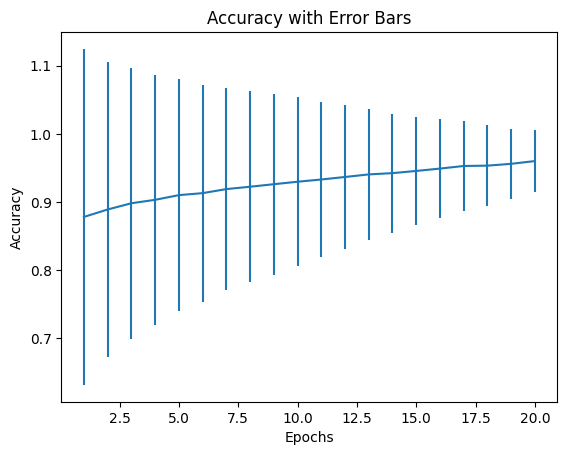

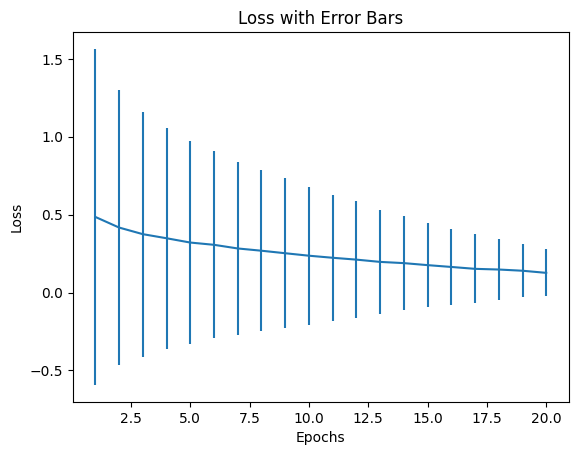

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# Define the early stopping callback
es = EarlyStopping(patience=8, restore_best_weights=True, monitor="val_acc")
STEPS = len(X_train) / 256

# Create lists to store history objects
history_objects = []

# Loop over the training phases
for _ in range(10):
    # Train the model with early stopping callback
    history = model.fit(aug.flow(X_train, Y_train, batch_size=256),
                        steps_per_epoch=STEPS,
                        batch_size=256,
                        epochs=20,
                        validation_data=(X_train, Y_train),
                        callbacks=[es])

    # Store history object
    history_objects.append(history)

# Extract relevant metrics for plotting
accuracy_values = [history.history['accuracy'] for history in history_objects]
loss_values = [history.history['loss'] for history in history_objects]

# Calculate mean and standard deviation
mean_accuracy = np.mean(accuracy_values, axis=0)
std_accuracy = np.std(accuracy_values, axis=0)
mean_loss = np.mean(loss_values, axis=0)
std_loss = np.std(loss_values, axis=0)

def plot_model_history(metric_name, mean_values, std_values):
    epochs = range(1, len(mean_values) + 1)  # Create x-axis values for epochs
    plt.errorbar(epochs, mean_values, yerr=std_values)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} with Error Bars')
    plt.show()

plot_model_history('Accuracy', mean_accuracy, std_accuracy)
plot_model_history('Loss', mean_loss, std_loss)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


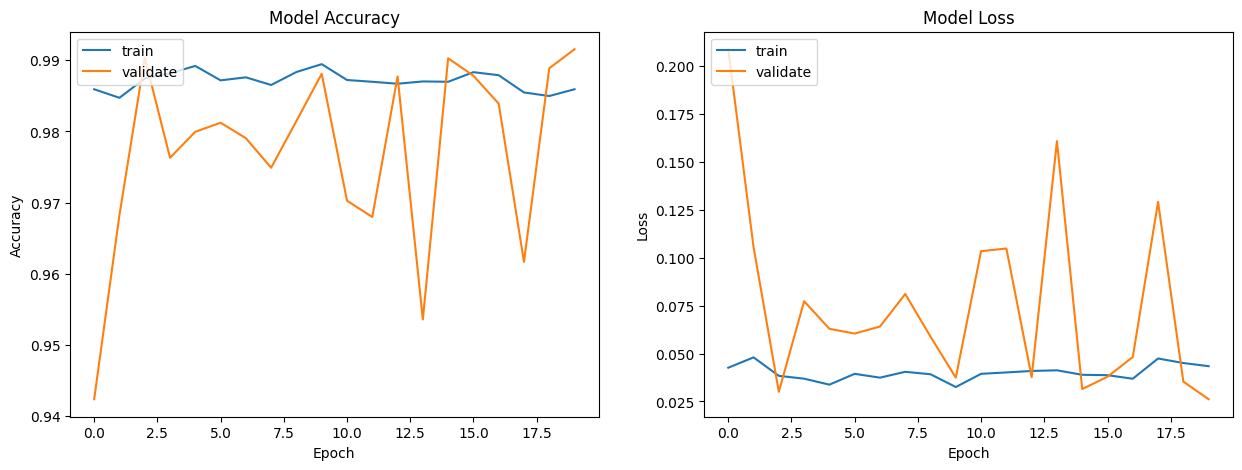

In [21]:
def plotmodelhistory(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')

    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [22]:

ModelLoss, ModelAccuracy = model.evaluate(X_train, Y_train)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

1250/1250 [==============================] - 7s 5ms/step - loss: 0.0262 - accuracy: 0.9916
Model Loss is 0.02616269141435623
Model Accuracy is 0.9915500283241272


In [23]:
# Assuming you have trained the model and stored it in the 'model' variable
from sklearn.metrics import confusion_matrix
# Make predictions on the test set
Y_pred = model.predict(X_test)
# Convert the one-hot encoded predictions and true labels to their original form
Y_pred_labels = np.argmax(Y_pred, axis=1)
Y_true_labels = np.argmax(Y_test, axis=1)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(Y_true_labels, Y_pred_labels)
print("Confusion Matrix:")
print(confusion_mat)


313/313 [==============================] - 2s 5ms/step
Confusion Matrix:
[[71  0  0 ...  0  1  0]
 [ 2 62  0 ...  0  0  1]
 [ 1  1 33 ...  0  3  0]
 ...
 [ 0  0  0 ... 47  2  0]
 [ 0  1  4 ...  1 21  1]
 [ 0  0  0 ...  0  0 59]]


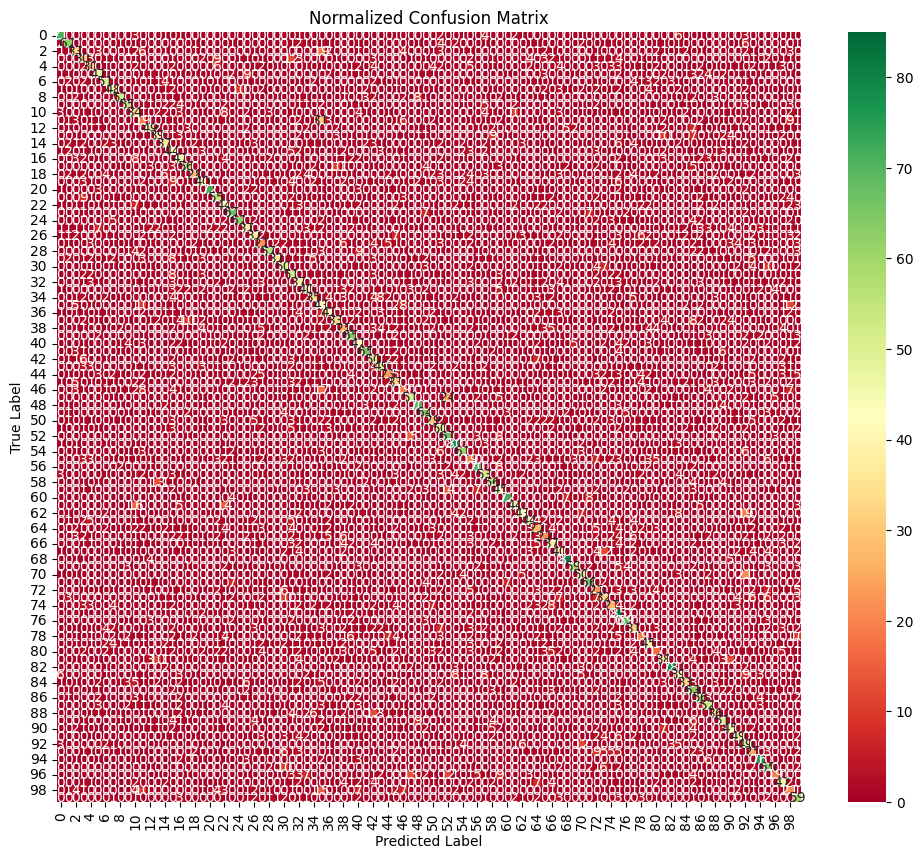

In [24]:
# Define class labels
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_mat, annot=True, cmap='RdYlGn', fmt='d')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [25]:
from sklearn.metrics import classification_report

# Assuming you have the true labels 'y_true' and predicted labels 'y_pred'

# Generate classification report
report = classification_report(Y_pred_labels,Y_true_labels)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       0.71      0.68      0.70       104
           1       0.62      0.67      0.65        92
           2       0.33      0.37      0.35        90
           3       0.30      0.28      0.29       106
           4       0.30      0.38      0.34        79
           5       0.47      0.54      0.50        87
           6       0.51      0.56      0.53        91
           7       0.48      0.53      0.50        91
           8       0.52      0.69      0.59        75
           9       0.55      0.66      0.60        83
          10       0.34      0.28      0.31       120
          11       0.19      0.18      0.19       104
          12       0.49      0.54      0.52        90
          13       0.39      0.45      0.42        86
          14       0.37      0.47      0.41        79
          15       0.44      0.29      0.35       154
          16       0.47      0.44      0.45       108
          17       0.56    